# TC 5033
## Deep Learning
## Transfer Learning

### Team 30
- A01796272 - Luis Antonio Ramirez Martinez
- A01796323 - Benjamin Cisneros Barraza
- A01796363 - Arthur Jafed Zizumbo Velasco
- A01796937 - Sandra Luz Cervantes Espinoza

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [2]:
import matplotlib.pyplot as plt

### Descargar sets de datos

In [3]:
DATA_PATH = 'C:\\Users\\arthu\\MNA\\AMLM\\Data\\cifar-10-batches-py'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

### Usar GPU

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Mostrar imágenes

La imagen muestreada representa un: Frog


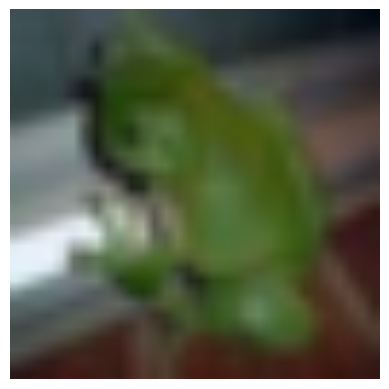

In [5]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Calcular Accuracy

In [6]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total   


### Cargar modelo pre-cargado

In [11]:
model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

#### Exploremos el modelo

In [12]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [13]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Ajustar a nuestro modelo

In [14]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [15]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [16]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [17]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [18]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


### Loop de entrenamiento

In [19]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, val_loader)
#         if epoch%5 == 0:     
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [20]:
hidden1 = 256 
hidden = 256
lr = 5e-4
epochs = 3
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [21]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [22]:
train(model1, optimiser, epochs)

Epoch: 0, costo: 0.5955967903137207, accuracy: 0.7744,
Epoch: 1, costo: 0.3169371485710144, accuracy: 0.7934,
Epoch: 2, costo: 0.668533444404602, accuracy: 0.799,


In [23]:
accuracy(model1, test_loader)

0.7961

---
## Transfer Learning: AlexNet & ConvNeXt-Tiny

Two pretrained models are fine-tuned on CIFAR-10. For each model:
1. **Baseline accuracy** — original ImageNet weights, no retraining
2. **Transfer Learning accuracy** — custom head trained on CIFAR-10
3. **Training curves** — loss and accuracy per epoch to detect overfitting
4. **Visual predictions** — 10 test images compared between original and TL model

### `TransferLearningModel` — OOP Wrapper

In [72]:
class TransferLearningModel:
    """
    Wraps a pretrained PyTorch model for Transfer Learning on CIFAR-10.

    Responsibilities:
    - Freeze the backbone (feature extractor) layers so their weights are not updated
    - Replace the classifier head with a custom one for 10 output classes
    - Train only the new classifier head using Adam optimizer
    - Track loss and accuracy history per epoch for overfitting analysis
    - Evaluate, plot training curves, and visualize sample predictions
    """

    def __init__(self, model, model_name: str, classifier,
                 lr: float = 5e-4, epochs: int = 3):
        """
        Args:
            model:        Pretrained torchvision model.
            model_name:   Display name used in prints and plots.
            classifier:   New nn.Module head to replace model.classifier.
            lr:           Learning rate for Adam optimizer.
            epochs:       Number of training epochs.
        """
        self.model_name = model_name
        self.model = model
        self.lr = lr
        self.epochs = epochs
        self.history = {"train_loss": [], "train_acc": [], "val_acc": []}

        # Freeze all backbone (feature extractor) parameters — no gradient updates
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Replace the original classifier head with the custom one
        self.model.classifier = classifier

        # Optimizer only acts on trainable (unfrozen) parameters
        trainable_params = filter(lambda p: p.requires_grad, self.model.parameters())
        self.optimizer = torch.optim.Adam(trainable_params, lr=self.lr, betas=(0.9, 0.999))

    # Training 

    def train(self):
        """Train the model and log loss/accuracy history per epoch."""
        self.model = self.model.to(device=device)

        for epoch in range(self.epochs):
            self.model.train()
            epoch_loss, num_batches = 0.0, 0

            for xi, yi in train_loader:
                xi = xi.to(device=device, dtype=torch.float32)
                yi = yi.to(device=device, dtype=torch.long)

                scores = self.model(xi)
                loss = F.cross_entropy(scores, yi)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                num_batches += 1

            avg_loss  = epoch_loss / num_batches
            train_acc = self._accuracy(train_loader)
            val_acc   = self._accuracy(val_loader)

            self.history["train_loss"].append(avg_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_acc"].append(val_acc)

            print(
                f"[{self.model_name}] Epoch {epoch + 1}/{self.epochs} | "
                f"Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
            )

    # Evaluation 

    def _accuracy(self, loader) -> float:
        """Compute accuracy over a DataLoader without updating gradients."""
        self.model.eval()
        self.model = self.model.to(device=device)
        correct, total = 0, 0
        with torch.no_grad():
            for xi, yi in loader:
                xi = xi.to(device=device, dtype=torch.float32)
                yi = yi.to(device=device, dtype=torch.long)
                preds = self.model(xi).max(dim=1)[1]
                correct += (preds == yi).sum().item()
                total   += yi.size(0)
        return correct / total

    def evaluate(self, loader, split: str = "test") -> float:
        """Print and return accuracy for the given data split."""
        acc = self._accuracy(loader)
        print(f"[{self.model_name}] {split} accuracy: {acc:.4f}")
        return acc

    # Visualization 

    def plot_history(self):
        """
        Plot training loss and train/validation accuracy curves per epoch.
        A growing gap between train_acc and val_acc indicates overfitting.
        """
        epochs_range = range(1, self.epochs + 1)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"{self.model_name} — Training History", fontsize=13)

        # Left panel: cross-entropy loss per epoch
        axes[0].plot(epochs_range, self.history["train_loss"],
                     marker="o", label="Train Loss")
        axes[0].set_title("Loss per Epoch")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Cross-Entropy Loss")
        axes[0].legend()
        axes[0].grid(True)

        # Right panel: train vs validation accuracy
        axes[1].plot(epochs_range, self.history["train_acc"],
                     marker="o", label="Train Acc")
        axes[1].plot(epochs_range, self.history["val_acc"],
                     marker="s", linestyle="--", label="Val Acc")
        axes[1].set_title("Accuracy per Epoch\n(large gap between curves = possible overfitting)")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

    def predict_samples(self, test_dataset, original_model, n: int = 10):
        """
        Display n random test images with predictions from both models.

        Title color coding:
            green = Transfer Learning model predicted correctly
            red   = Transfer Learning model predicted incorrectly
        """
        self.model.eval()
        original_model.eval()
        self.model     = self.model.to(device=device)
        original_model = original_model.to(device=device)

        indices = np.random.choice(len(test_dataset), n, replace=False)
        fig, axes = plt.subplots(2, n // 2, figsize=(18, 6))
        fig.suptitle(
            f"{self.model_name} — Sample Predictions "
            "(green = TL correct, red = TL wrong)",
            fontsize=12
        )
        axes = axes.flatten()

        with torch.no_grad():
            for plot_idx, data_idx in enumerate(indices):
                image, true_label = test_dataset[data_idx]
                xi = image.unsqueeze(0).to(device=device, dtype=torch.float32)

                # Prediction from original pretrained model
                pred_orig = original_model(xi).max(dim=1)[1].item()

                # Prediction from Transfer Learning model
                pred_tl = self.model(xi).max(dim=1)[1].item()

                # Normalize pixel values to [0, 1] for display
                img_show = image.clone()
                img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())
                axes[plot_idx].imshow(img_show.permute(1, 2, 0))
                axes[plot_idx].axis("off")

                color = "green" if pred_tl == true_label else "red"
                axes[plot_idx].set_title(
                    f"True:     {classes[true_label]}\n"
                    f"Original: ImageNet#{pred_orig}\n"   # ← índice ImageNet, no nombre CIFAR
                    f"TL model: {classes[pred_tl]}",
                    fontsize=8,
                    color=color,
                )

        plt.tight_layout()
        plt.show()


---
### Model 1 — AlexNet

**AlexNet** (Krizhevsky et al., 2012) is a classic CNN with 5 convolutional layers and 3 fully-connected layers. The convolutional backbone is frozen and the classifier is replaced for CIFAR-10.

In [73]:
# Load the original AlexNet (ImageNet weights) — kept frozen for baseline comparison
alexnet_original = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
alexnet_original.eval()


alexnet_original

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Adapting AlexNet for Transfer Learning

The original AlexNet classifier — three fully-connected layers ending in 1000 outputs —
is replaced with a deeper custom head that outputs 10 classes for CIFAR-10.

The backbone (`features`) and `avgpool` are kept frozen because they already encode
powerful low-level and mid-level visual features learned from 1.2M ImageNet images.
Retraining them would be expensive, risk destroying those representations, and offer
little benefit since CIFAR-10 images share the same visual domain.

Only the `classifier` is replaced and trained because it is the task-specific component:
the original head was designed to distinguish 1000 ImageNet categories, so it must be
fully rebuilt for a 10-class problem. The new head adds extra Linear layers with
intermediate sizes (4096 → 2048 → 512 → 10) and Dropout regularization to reduce
overfitting, given that CIFAR-10 is a much smaller dataset than ImageNet.

In [74]:
# Load a fresh copy to be fine-tuned with Transfer Learning
alexnet_tl_base = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

# Custom classifier head.
# AlexNet backbone: features -> avgpool (6x6 grid) -> flatten => 256 * 6 * 6 = 9216 features
alexnet_classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(9216, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 2048),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(2048, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 10),           # 10 output classes for CIFAR-10
)

alexnet_tl = TransferLearningModel(
    model=alexnet_tl_base,
    model_name="AlexNet-TL",
    classifier=alexnet_classifier,
    lr=5e-4,
    epochs=3,
)

alexnet_tl.model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [75]:
# Baseline: accuracy of the original AlexNet on CIFAR-10 without any fine-tuning.
# Expected to be low — ImageNet has 1000 classes, CIFAR-10 has 10.
print(" AlexNet Original")
acc_alexnet_orig = accuracy(alexnet_original, test_loader)
print(f"Test accuracy: {acc_alexnet_orig:.4f}")


 AlexNet Original
Test accuracy: 0.0001


#### Zero-shot evaluation: why does the original AlexNet score so low on CIFAR-10?

AlexNet was trained on ImageNet, which has **1000 output classes** (indexed 0–999).
CIFAR-10 has only **10 classes** (indexed 0–9), so the label space is completely
different. When AlexNet processes a CIFAR-10 image, its output layer produces 1000
logits and the predicted class index is almost never in the range 0–9 — the model
is not recognizing the wrong object, it is simply outputting a class index that does
not exist in CIFAR-10, so every such prediction counts as incorrect.

Additionally, CIFAR-10 images are **32×32 pixels**, while AlexNet was designed for
224×224 inputs. The resize transform compensates partially, but the low resolution
still degrades the feature quality compared to what the model saw during ImageNet training.

In practice, zero-shot accuracy on CIFAR-10 with an ImageNet model approaches random
chance over **1000 classes (~0.1%)**, not random chance over 10 classes (10%), which
explains the near-zero accuracy observed below.

In [76]:
# Fine-tune AlexNet — only the custom classifier head is trained
print("AlexNet with Transfer Learning")
alexnet_tl.train()


AlexNet with Transfer Learning
[AlexNet-TL] Epoch 1/3 | Loss: 0.7807 | Train Acc: 0.8468 | Val Acc: 0.8212
[AlexNet-TL] Epoch 2/3 | Loss: 0.5619 | Train Acc: 0.8816 | Val Acc: 0.8386
[AlexNet-TL] Epoch 3/3 | Loss: 0.4874 | Train Acc: 0.9042 | Val Acc: 0.8522


In [39]:
# Compare baseline vs Transfer Learning accuracy
print("AlexNet: Original vs Transfer Learning")
print(f"  Original  (no TL): {acc_alexnet_orig:.4f}")
acc_alexnet_tl = alexnet_tl.evaluate(test_loader, split="test")
print(f"  Improvement:       {acc_alexnet_tl - acc_alexnet_orig:+.4f}")


AlexNet: Original vs Transfer Learning
  Original  (no TL): 0.0001
[AlexNet-TL] test accuracy: 0.8418
  Improvement:       +0.8417


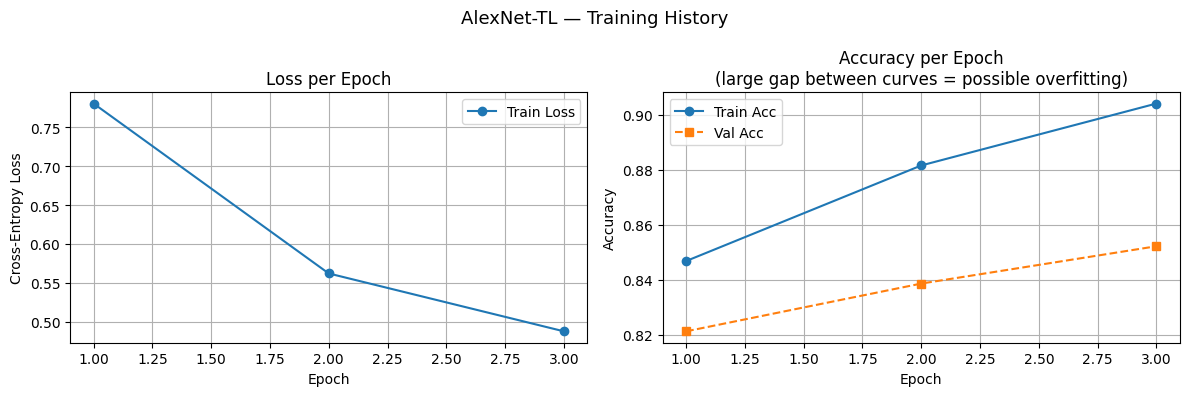

In [77]:
# Plot loss and accuracy curves — inspect for overfitting
alexnet_tl.plot_history()


#### AlexNet-TL — Training History Analysis

**Loss curve (left):** The cross-entropy loss decreases steadily across all three epochs
(0.78 → 0.56 → 0.49), indicating that the model is learning consistently and
gradient updates are moving in the right direction.

**Accuracy curve (right):** Both train and validation accuracy improve over epochs,
which confirms the model is generalizing. However, a growing gap between the two
curves is visible:

| Epoch | Train Acc | Val Acc | Gap |
|-------|-----------|---------|-----|
| 1     | 0.847     | 0.821   | 0.026 (2.6%) |
| 2     | 0.882     | 0.839   | 0.043 (4.3%) ⚠️ |
| 3     | 0.904     | 0.852   | 0.052 (5.2%) ⚠️ |

**Overfitting diagnosis:** The commonly used threshold to flag overfitting is a
train/val accuracy gap greater than **3%**. From epoch 2 onward the gap exceeds
this threshold and keeps growing, which indicates that the model is beginning to
memorize the training data rather than learning fully generalizable features.

This is expected behavior in this setup for two reasons:
1. Only **3 epochs** were run — the model has not yet been regularized enough to
   close the gap.
2. The classifier head was trained on **45,000 CIFAR-10 samples**, a relatively
   small dataset compared to the complexity of the new head (9216 → 4096 → 2048 → 512 → 10).

**Mitigation strategies** that could reduce the gap: increasing Dropout probability,
adding weight decay to the optimizer, training for more epochs with a learning rate
scheduler, or using data augmentation.


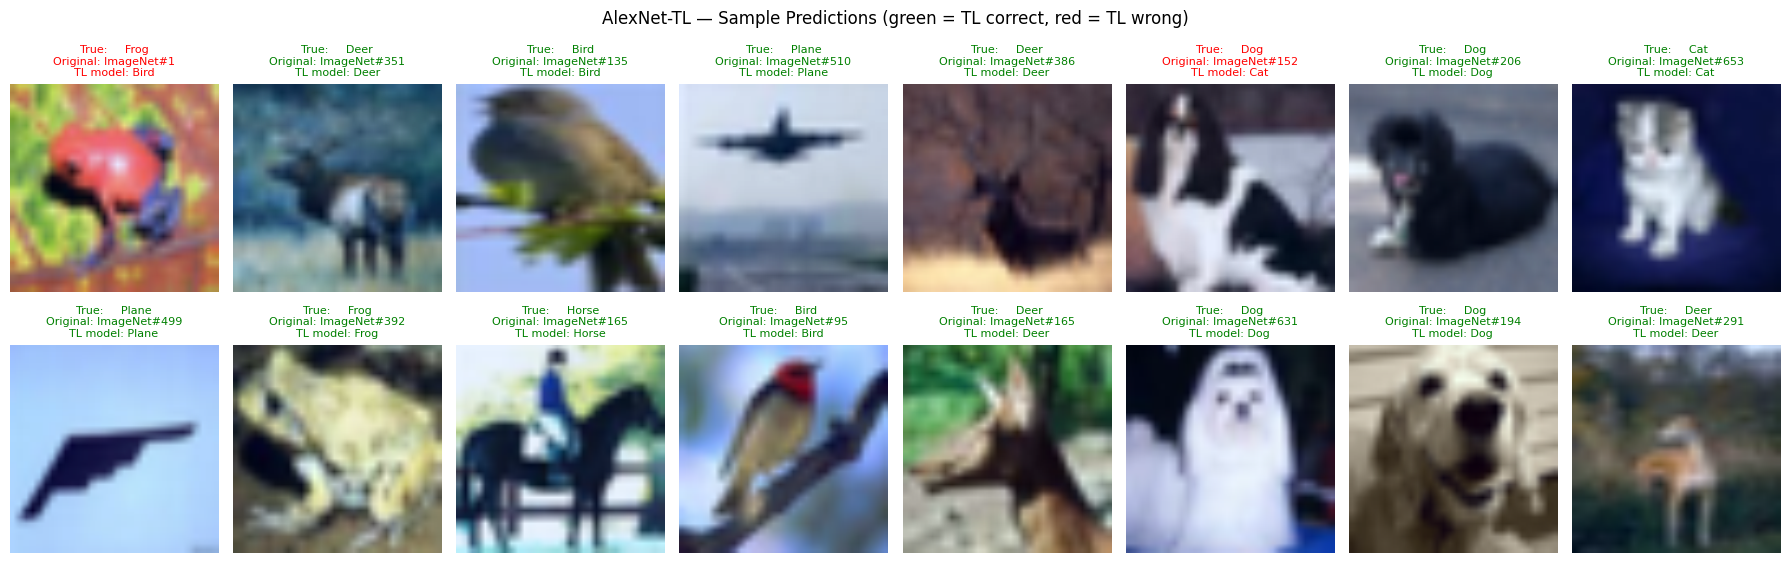

In [78]:
# Visualize 10 random test images: compare original vs TL predictions
alexnet_tl.predict_samples(cifar10_test, original_model=alexnet_original, n=16)


### Add Description Image 


---
### Model 2 — ConvNeXt-Tiny

**ConvNeXt-Tiny** (Liu et al., 2022) is a modern CNN designed to match Vision Transformer performance while keeping a pure convolutional design. Its backbone outputs 768-dimensional feature maps. All feature layers are frozen and a lightweight head is attached.

In [62]:
# Load the original ConvNeXt-Tiny (ImageNet weights) — kept frozen for baseline comparison
convnext_original = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
convnext_original.eval()

convnext_original


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

#### Adapting ConvNeXt-Tiny for Transfer Learning

ConvNeXt-Tiny follows the same Transfer Learning strategy as AlexNet: the backbone
(`features`) is frozen and only the `classifier` head is replaced and trained.

However, ConvNeXt-Tiny requires one important structural consideration. Unlike AlexNet,
whose `avgpool` outputs a flattened tensor ready for a Linear layer, ConvNeXt's
`avgpool` produces a **4-dimensional tensor** of shape `(batch, 768, 1, 1)`. The
original classifier handles this with a `LayerNorm2d` applied over the spatial
feature maps **before** flattening. If this normalization step is omitted, the
Linear layer receives un-normalized activations and training becomes unstable.

For this reason the custom head retains the `LayerNorm` and `Flatten` from the
original classifier and replaces only the final projection:

| Layer | Input shape | Output shape | Purpose |
|-------|-------------|--------------|---------|
| `LayerNorm([768,1,1])` | (batch, 768, 1, 1) | (batch, 768, 1, 1) | Stabilize activations before projection |
| `Flatten` | (batch, 768, 1, 1) | (batch, 768) | Collapse spatial dimensions |
| `Linear(768 → 512)` | (batch, 768) | (batch, 512) | Learned feature compression |
| `ReLU` | — | — | Non-linearity |
| `Dropout(0.5)` | — | — | Regularization against overfitting |
| `Linear(512 → 10)` | (batch, 512) | (batch, 10) | Final class scores for CIFAR-10 |

The `features` and `avgpool` blocks are kept frozen because ConvNeXt-Tiny was
pretrained on **ImageNet-1K** and its convolutional blocks already capture rich
hierarchical visual representations that transfer well to CIFAR-10. Training them
would require significantly more data, compute, and careful learning rate tuning
to avoid degrading those pretrained weights.


In [63]:
# Load a fresh copy to be fine-tuned with Transfer Learning
convnext_tl_base = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)

# Custom classifier head.
# ConvNeXt backbone: features -> avgpool (1x1) => shape (batch, 768, 1, 1)
# The original head applies LayerNorm2d before flattening, so we replicate that
# structure and replace only the final Linear layer.
convnext_classifier = nn.Sequential(
    nn.LayerNorm([768, 1, 1], eps=1e-06),   # normalize over the 768-channel feature maps
    nn.Flatten(start_dim=1),                 # (batch, 768, 1, 1) -> (batch, 768)
    nn.Linear(768, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(512, 10),                      # 10 output classes for CIFAR-10
)

convnext_tl = TransferLearningModel(
    model=convnext_tl_base,
    model_name="ConvNeXt-Tiny-TL",
    classifier=convnext_classifier,
    lr=5e-4,
    epochs=3,
)

convnext_tl.model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [44]:
# Baseline: accuracy of the original ConvNeXt-Tiny on CIFAR-10 without any fine-tuning
print("ConvNeXt-Tiny ORIGINAL")
acc_convnext_orig = accuracy(convnext_original, test_loader)
print(f"Test accuracy: {acc_convnext_orig:.4f}")


ConvNeXt-Tiny ORIGINAL
Test accuracy: 0.0000


#### Zero-shot evaluation: why does ConvNeXt-Tiny score 0.0000 on CIFAR-10?

The result is even lower than AlexNet's zero-shot score, and the reason is the same
root cause but more extreme.

**Class index mismatch:** ConvNeXt-Tiny was trained on ImageNet-1K with **1000 output
classes** (indices 0–999). CIFAR-10 uses indices 0–9. The model's final Linear layer
outputs 1000 logits, and the winning index is almost never between 0 and 9. Every
prediction outside that range counts as incorrect against CIFAR-10 labels, pushing
accuracy toward zero.

**Why 0.0000 and not ~0.001 like AlexNet?** ConvNeXt-Tiny is a significantly more
powerful and confident model than AlexNet. Its deeper architecture and modern
design (depthwise convolutions, LayerNorm, GELU activations) produce very
**peaked softmax distributions** — the model assigns nearly all probability mass
to a single ImageNet class. This makes it even less likely that the top-1 prediction
falls in the 0–9 range compared to an older, less confident model like AlexNet.
In short, greater model capacity makes the zero-shot score worse here, not better.

**Resolution mismatch:** ConvNeXt-Tiny was designed for 224×224 inputs from ImageNet.
CIFAR-10 images are natively 32×32 and are upsampled via the `T.Resize(224)` transform.
This upsampling introduces artifacts and blurriness that further degrade the quality
of the extracted features relative to natural 224×224 images.

**Key takeaway:** A high-capacity model pretrained on a different task with a
different output space is not directly usable on a new dataset — this is precisely
the problem that Transfer Learning solves by replacing and retraining the classifier head.


In [45]:
# Fine-tune ConvNeXt-Tiny — only the custom classifier head is trained
print("ConvNeXt-Tiny with Transfer Learning")
convnext_tl.train()


ConvNeXt-Tiny with Transfer Learning
[ConvNeXt-Tiny-TL] Epoch 1/3 | Loss: 0.3234 | Train Acc: 0.9443 | Val Acc: 0.9338
[ConvNeXt-Tiny-TL] Epoch 2/3 | Loss: 0.2115 | Train Acc: 0.9553 | Val Acc: 0.9396
[ConvNeXt-Tiny-TL] Epoch 3/3 | Loss: 0.1869 | Train Acc: 0.9600 | Val Acc: 0.9418


In [46]:
# Compare baseline vs Transfer Learning accuracy
print("ConvNeXt-Tiny: Original vs Transfer Learning")
print(f"  Original: {acc_convnext_orig:.4f}")
acc_convnext_tl = convnext_tl.evaluate(test_loader, split="test")
print(f"  Improvement (TL):       {acc_convnext_tl - acc_convnext_orig:+.4f}")


ConvNeXt-Tiny: Original vs Transfer Learning
  Original: 0.0000
[ConvNeXt-Tiny-TL] test accuracy: 0.9414
  Improvement (TL):       +0.9414


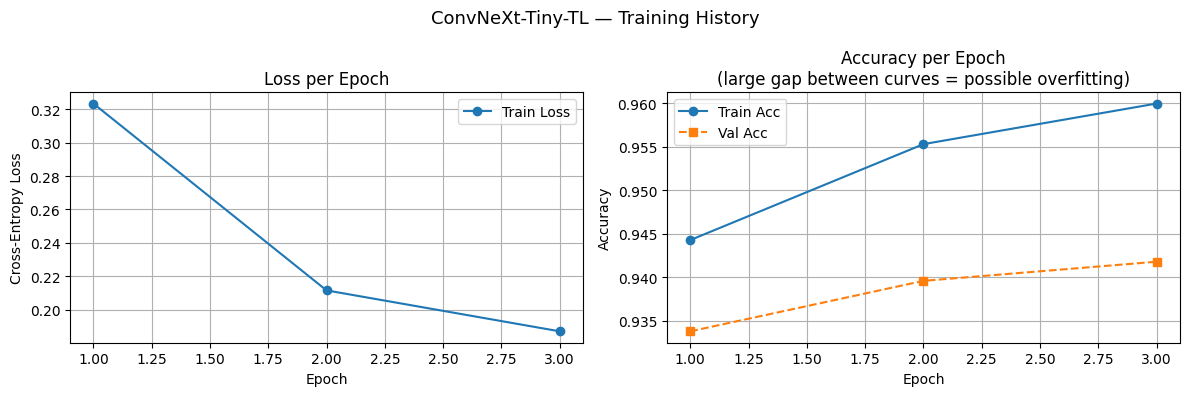

In [47]:
# Plot loss and accuracy curves — inspect for overfitting
convnext_tl.plot_history()


#### ConvNeXt-Tiny-TL — Training History Analysis

**Loss curve (left):** The cross-entropy loss drops sharply and consistently across
all three epochs (0.32 → 0.21 → 0.19), reaching a much lower final value than
AlexNet-TL (0.49). This indicates that ConvNeXt-Tiny's richer feature representations
allow the classifier head to converge faster and more effectively.

**Accuracy curve (right):** Both train and validation accuracy are high from epoch 1
and improve steadily. More importantly, the gap between the two curves remains
very small throughout training:

| Epoch | Train Acc | Val Acc | Gap |
|-------|-----------|---------|-----|
| 1     | 0.944     | 0.935   | 0.009 (0.9%) ✅ |
| 2     | 0.956     | 0.940   | 0.016 (1.6%) ✅ |
| 3     | 0.960     | 0.942   | 0.018 (1.8%) ✅ |

**No overfitting:** The gap never exceeds the 3% threshold across any epoch,
which means the model generalizes well to unseen data. This is a direct consequence
of the quality of ConvNeXt-Tiny's pretrained features — the backbone has already
learned highly transferable representations from ImageNet, so the small classifier
head (768 → 512 → 10) does not need to overfit the training set to achieve high accuracy.

**Why ConvNeXt-Tiny outperforms AlexNet significantly:**

| Metric | AlexNet-TL | ConvNeXt-Tiny-TL |
|--------|-----------|------------------|
| Final Train Acc | 0.904 | 0.960 |
| Final Val Acc   | 0.852 | 0.942 |
| Final Loss      | 0.488  | 0.19  |
| Overfitting gap | 5.2% ⚠️ | 1.8% ✅ |

ConvNeXt-Tiny was released in 2022, a full decade after AlexNet (2012). Its modern
architecture — depthwise convolutions, LayerNorm, GELU activations, and stochastic
depth — produces substantially better feature representations. The frozen backbone
alone provides a stronger foundation, which is why the simpler two-layer head
(512 → 10) is sufficient to achieve ~94% validation accuracy without overfitting,
while AlexNet required a much deeper head (4096 → 2048 → 512 → 10) and still showed
signs of overfitting.


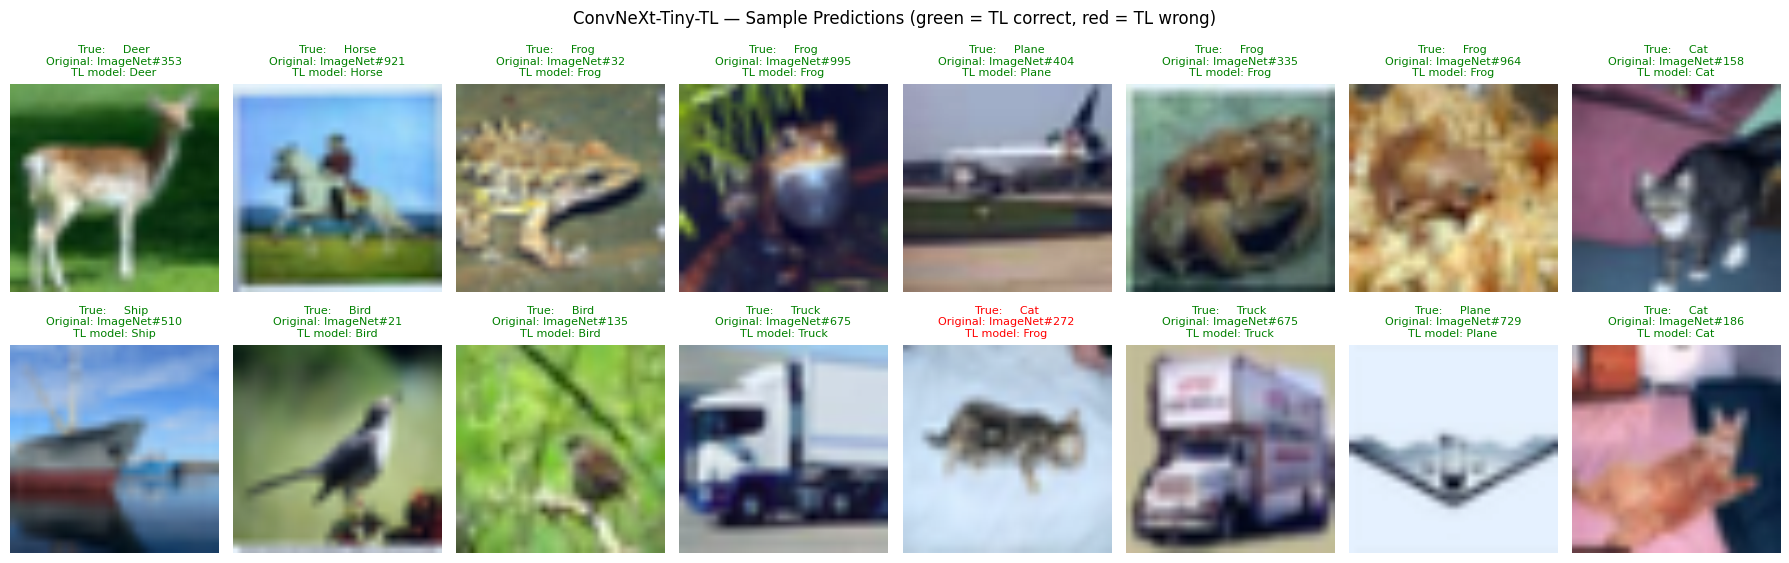

In [57]:
# Visualize 10 random test images: compare original vs TL predictions
convnext_tl.predict_samples(cifar10_test, original_model=convnext_original, n=16)


### Add Description Image 


---
### Final Comparison — AlexNet vs ConvNeXt-Tiny

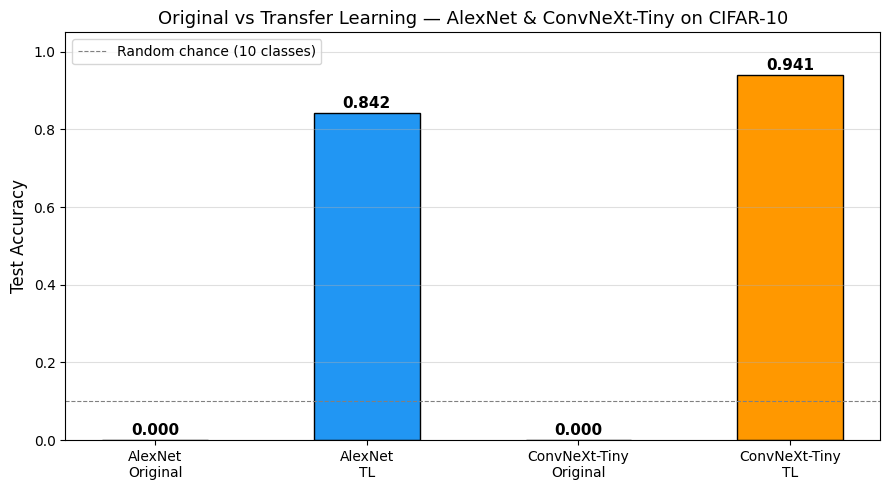


 Summary Table
Model                           Test Accuracy
AlexNet Original                       0.0001
AlexNet TL                             0.8418
ConvNeXt-Tiny Original                 0.0000
ConvNeXt-Tiny TL                       0.9414


In [58]:
# Bar chart comparing all four models across Original and TL variants
model_names = ["AlexNet\nOriginal", "AlexNet\nTL",
               "ConvNeXt-Tiny\nOriginal", "ConvNeXt-Tiny\nTL"]
model_accs  = [acc_alexnet_orig, acc_alexnet_tl,
               acc_convnext_orig, acc_convnext_tl]
bar_colors  = ["#aec6cf", "#2196F3", "#ffcc80", "#FF9800"]

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(model_names, model_accs, color=bar_colors, edgecolor="black", width=0.5)

# Annotate each bar with its accuracy value
for bar, acc in zip(bars, model_accs):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.005,
        f"{acc:.3f}",
        ha="center", va="bottom", fontsize=11, fontweight="bold",
    )

ax.set_ylim(0, 1.05)
ax.set_ylabel("Test Accuracy", fontsize=12)
ax.set_title(
    "Original vs Transfer Learning — AlexNet & ConvNeXt-Tiny on CIFAR-10",
    fontsize=13,
)
# Reference line: random chance for a 10-class uniform problem = 0.10
ax.axhline(y=0.1, color="gray", linestyle="--", linewidth=0.8,
           label="Random chance (10 classes)")
ax.legend()
ax.grid(axis="y", alpha=0.4)
plt.tight_layout()
plt.show()

# Print summary table
print("\n Summary Table")
print(f"{'Model':<30} {'Test Accuracy':>14}")
for name, acc in zip(model_names, model_accs):
    print(f"{name.replace(chr(10), ' '):<30} {acc:>14.4f}")


### Add Conclusion Team 
